<a href="https://colab.research.google.com/github/newman001/neural-net-for-classification/blob/master/MNIST_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [69]:
x_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
x_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [70]:
x_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [0]:
x_train = x_train.float()
x_test = x_test.float()

In [72]:
x_train.shape, x_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [73]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

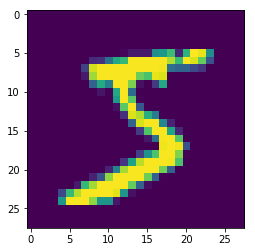

tensor(5)


In [74]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0, :, :])
plt.show()
print(y_train[0])

In [0]:
x_train = x_train.reshape([-1, 28*28])
x_test = x_test.reshape([-1, 28*28])

In [0]:
class MNISTNet(torch.nn.Module):
  def __init__(self, n_hidden_neurons):
    super(MNISTNet, self).__init__()
    self.fc1 = torch.nn.Linear(28*28, n_hidden_neurons)
    self.ac1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)
    
  def forward(self, x):
    x = self.fc1(x)
    x = self.ac1(x)
    x = self.fc2(x)
    return x
  
mnist_net = MNISTNet(100)

In [77]:
torch.cuda.is_available()

True

In [78]:
!nvidia-smi

Fri Jun 28 10:31:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    73W / 149W |   4165MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [79]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0221,  0.0258, -0.0088,  ..., -0.0141,  0.0051, -0.0318],
         [-0.0217, -0.0136,  0.0185,  ..., -0.0012, -0.0012, -0.0017],
         [ 0.0142,  0.0089, -0.0053,  ...,  0.0311, -0.0181,  0.0020]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-3.5402e-02,  1.8178e-02, -2.1709e-02, -1.1839e-02,  4.8722e-03,
         -1.0492e-02, -1.9008e-02,  2.6994e-02, -3.4899e-02,  1.0381e-02,
         -3.5228e-02, -5.6381e-03, -2.0134e-02, -3.0264e-02, -1.3289e-02,
          2.5346e-02, -1.0797e-02,  2.1568e-03,  4.3630e-03, -2.1916e-02,
          2.2670e-02, -1.5766e-02,  3.4906e-02, -2.3063e-02, -6.8216e-03,
          2.7051e-02, -1.3991e-02,  9.7218e-03, -9.9075e-04,  1.6625e-03,
          2.3455e-02, -2

In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [81]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

x_test = x_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
  order = np.random.permutation(len(x_train))
  
  for start_index in range(0, len(x_train), batch_size):
    optimizer.zero_grad()
    
    batch_indexes = order[start_index:start_index+batch_size]
    
    x_batch = x_train[batch_indexes].to(device)
    y_batch = y_train[batch_indexes].to(device)
    
    preds = mnist_net.forward(x_batch)
    
    loss_value = loss(preds, y_batch)
    loss_value.backward()
    
    optimizer.step()
  
  test_preds = mnist_net.forward(x_test)
  test_loss_history.append(loss(test_preds, y_test))
  
  accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
  test_accuracy_history.append(accuracy)
  print(accuracy)

tensor(0.9093, device='cuda:0')
tensor(0.9167, device='cuda:0')
tensor(0.9207, device='cuda:0')
tensor(0.9283, device='cuda:0')
tensor(0.9233, device='cuda:0')
tensor(0.9267, device='cuda:0')
tensor(0.9249, device='cuda:0')
tensor(0.9298, device='cuda:0')
tensor(0.9274, device='cuda:0')
tensor(0.9325, device='cuda:0')
tensor(0.9328, device='cuda:0')
tensor(0.9320, device='cuda:0')
tensor(0.9356, device='cuda:0')
tensor(0.9343, device='cuda:0')
tensor(0.9397, device='cuda:0')
tensor(0.9325, device='cuda:0')
tensor(0.9389, device='cuda:0')
tensor(0.9383, device='cuda:0')
tensor(0.9390, device='cuda:0')
tensor(0.9329, device='cuda:0')
tensor(0.9366, device='cuda:0')
tensor(0.9387, device='cuda:0')
tensor(0.9381, device='cuda:0')
tensor(0.9381, device='cuda:0')
tensor(0.9371, device='cuda:0')
tensor(0.9419, device='cuda:0')
tensor(0.9412, device='cuda:0')
tensor(0.9454, device='cuda:0')
tensor(0.9431, device='cuda:0')
tensor(0.9437, device='cuda:0')
tensor(0.9441, device='cuda:0')
tensor(0

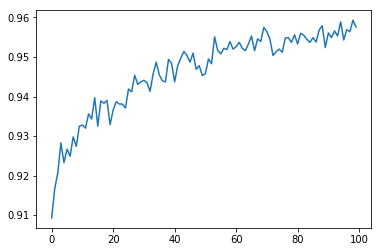

In [82]:
plt.plot(test_accuracy_history)


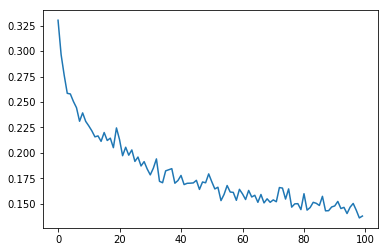

In [83]:
plt.plot(test_loss_history)